# Improve Occupancy Detection models

This Notebook explores the [Occupancy Detection Data Set](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+) and builds upon the excellent work of Omer Turksoy, published in Kaggle: [HVAC Occupancy Detection with ML and DL Methods](https://www.kaggle.com/turksoyomer/hvac-occupancy-detection-with-ml-and-dl-methods).

Occupancy data comes into three parts: `dataset.txt`, `dataset2.txt`, and `datatraining.txt`. The latter should be used for model training, and the others - for model validation and testing, respectively. Ground-truth occupancy was obtained from time stamped pictures taken every minute. Datasets hold information about room properties, e.g., temperature, humidity, CO2, etc. Predictions could be used by companies and property managers to plan Heating, Ventilating and Air Conditioning (HVAC). 

Initially, I planned only to explore the data and the modelling approach. It turned out however, that the provided datasets are mismatched. Hence, I improved train-validation-test split, which resulted in slightly better model performance. Furthermore, I wrapped almost all computations and transformations in functions to avoid redundant scripts.

The work is organised into several sections: Load the data, Exploratory Data Analysis, Data Preprocessing, Modelling, and Conclusion.

#### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [3]:
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
import plotly.express as px
import plotly.graph_objects as go

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2, l1

## 1. Load data

The three datasets are loaded and stored in variables. The heading rows are displayed thereafter.

In [7]:
dataset = pd.read_csv("data\datatest.txt")
dataset.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [8]:
dataset2 = pd.read_csv("data\datatest2.txt")
dataset2.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [9]:
datatraining = pd.read_csv("data\datatraining.txt")
datatraining.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


## 2. Exploratory Data Analysis

### 2.1. Check **dtype**, **shape** and **missing values**

`dataset` (validation data) has 2665 entries and 7 columns (features). All but two hold *float* values. Values in `date` are *strings*, and those in `Occupancy` - *integers*. There are not missing values in this dataset.

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB


Test data (`dataset2`) holds information about 9752 observations. It has the same number of features. Their value type is identical to those in the previous dataset. There are not missing entries, either.

In [11]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           9752 non-null   object 
 1   Temperature    9752 non-null   float64
 2   Humidity       9752 non-null   float64
 3   Light          9752 non-null   float64
 4   CO2            9752 non-null   float64
 5   HumidityRatio  9752 non-null   float64
 6   Occupancy      9752 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 609.5+ KB


Training data (`datatraining`) displays the same properties. However, it has less samples (8143) than the testing set.

In [12]:
datatraining.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


> `date` holds information about the date and time when an observation was recorded

> `Temperature` values are in *Celsius*

> `Humidity` shows the relative humidity as a percentage

> `Light` levels in the room are measured in *lux*

> `CO2` - Carbon dioxide levels are measured in parts per million

> `Humidity ratio` is derived from temperature and relative humidity. It is measured in kilograms of water vapor per kilogram of air
    
> `Occupancy` is either 1 for occupied or 0 for not occupied room

In the cited Notebook, `datatraining` (8143 instances) is used for training, `datatest` (2665 instances) - for validation, and `datatest2`(9752 instances) - for model testing. I think this is a wrong approach because the model was trained on samples occured in time after those in validation data. Also, a modelling algorithm should be trained on as many samples as possible to avoid under- or overfitting. The author's approach trains the model on 8143 entries and tests it on more - 9752. I found a workaround to address these problems, which led to better model performance.

### 2.2. Convert `date` to `datetime` type

`date` column needs to be converted into *datetime* type to allow further exploration and visualization. The function below does exactly this. It also resets dataframes' indices since index column in one of them was not ordered.

In [13]:
def convert_to_datetime(dataset):
    """
    Converts "date" column into "datetime" dtype.
    Args:
        Pandas DataFrame
    Return:
        Pandas DataFrame where "date" column in "datetime" type.
    """
    dataset["date"] = pd.to_datetime(dataset["date"])
    dataset.reset_index(drop = True, inplace = True)
    
    return dataset

In [14]:
dataset = convert_to_datetime(dataset)
dataset2 = convert_to_datetime(dataset2)
datatraining = convert_to_datetime(datatraining)

### 2.3. Explore time span

To explore start and end dates in all datasets, `date` needs to be set as *index*. For this reason, I make a copy of all sets to avoid mismatch at a later stage. 

In [15]:
dataset_copy = dataset.copy()
dataset2_copy = dataset2.copy()
datatraining_copy = datatraining.copy()

In [16]:
dataset_copy = dataset_copy.set_index("date")
dataset2_copy = dataset2_copy.set_index("date")
datatraining_copy = datatraining_copy.set_index("date")

The easliest date in `datatraining` is 4-th Feb, 2015, whereas the start date in validation data (`dataset`) is 2-nd Feb, 2015 - two days earlier. If the three sets are used as the author of the cited Notebook did, all modelling algorithms will be validated on dates preceeding those in the training data. I think this is not correct for time series. Nonetheless, before to rearrange splitting, I explore datasets' values.

In [17]:
print(f"Earliest date in 'dataset': {dataset_copy.index.min()}; Latest date in 'dataset': {dataset_copy.index.max()}")
print(f"Earliest date in 'dataset2': {dataset2_copy.index.min()}; Latest date in 'dataset2': {dataset2_copy.index.max()}")
print(f"Earliest date in 'datatraining': {datatraining_copy.index.min()}; Latest date in 'datatraining': {datatraining_copy.index.max()}")

Earliest date in 'dataset': 2015-02-02 14:19:00; Latest date in 'dataset': 2015-02-04 10:43:00
Earliest date in 'dataset2': 2015-02-11 14:48:00; Latest date in 'dataset2': 2015-02-18 09:19:00
Earliest date in 'datatraining': 2015-02-04 17:51:00; Latest date in 'datatraining': 2015-02-10 09:33:00


It is interesting to see how values fluctuate over time. Column names are stored in a list. It is used for plotting room properties, as shown below.

In [18]:
cols_plot = ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]

In [19]:
def plot_params_against_time(dataframe):
    """
    Plots room occupancy parameters (e.g., Temperature, Humidity, etc.)
    Args:
        Pandas DataFrame
    """
    axes = dataframe[cols_plot].plot(marker = ',', alpha = 0.5, linestyle = 'None', linewidth = 0.1, figsize = (14, 9), subplots = True)
    for ax in axes:
        ax.set_ylabel('Measure')

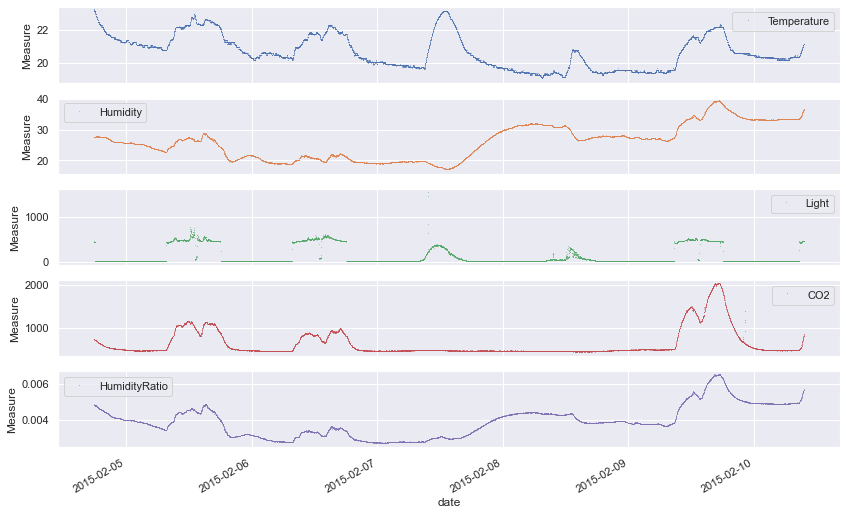

In [20]:
plot_params_against_time(datatraining_copy)

Datapoints per hour are not so visible on the plot above due to the higher number of samples. However, validation samples are shown per hour (see below). Thus, it could be seen that the temperature decreases in the evening (after 19 o'clock), and rises in the morning (around 8.00 am). Humidity follows the sampe pattern. The third plot indicates that either there is a light in the room (during daytime), or not (during evening and night). CO2 levels rise when the room is (most likely) occupied. HumidityRatio follows Humidity patters since its values are derived from the latter.

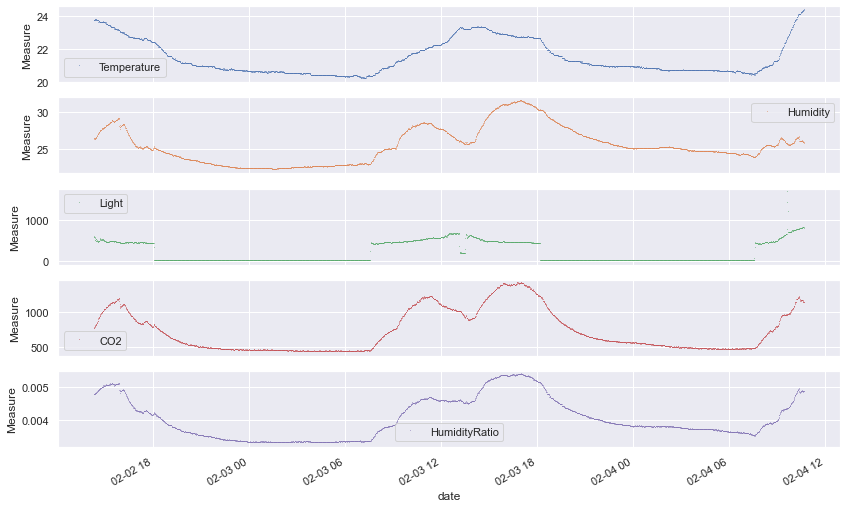

In [21]:
plot_params_against_time(dataset_copy)

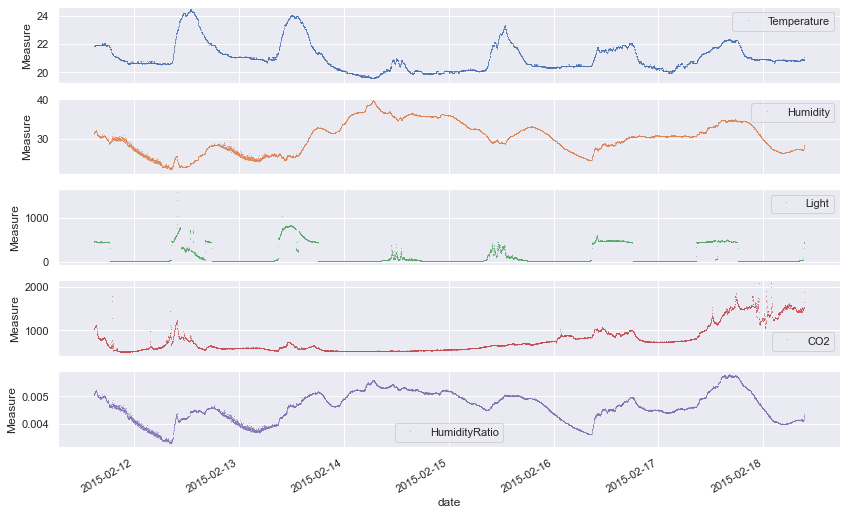

In [22]:
plot_params_against_time(dataset2_copy)

### 2.4. Scale Features

Feature scaling is a data preprocessing step and is not part of Data Exploration. I would have explored outliers before choosing a scaling algorithm. `MinMaxScaler()` is more popular and easier for understanding, whereas `StandardScaler()` handles outliers much better. Nonetheless, I stick to the approach proposed by the cited author.

The codeline below shows that values in `CO2` are in a broad range, whereas those in the other features in a much narrower one. If values are not normalized (scaled), the modelling algorithms will think that `CO2` values are more important than the ones in the other features and will asign `CO2` a higher weight. Data normalization addresses this problem.

In [23]:
datatraining.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,8143.0,20.619084,1.016916,19.000000,19.700000,20.390000,21.390000,23.180000
Humidity,8143.0,25.731507,5.531211,16.745000,20.200000,26.222500,30.533333,39.117500
Light,8143.0,119.519375,194.755805,0.000000,0.000000,0.000000,256.375000,1546.333333
CO2,8143.0,606.546243,314.320877,412.750000,439.000000,453.500000,638.833333,2028.500000
HumidityRatio,8143.0,0.003863,0.000852,0.002674,0.003078,0.003801,0.004352,0.006476
Occupancy,8143.0,0.212330,0.408982,0.000000,0.000000,0.000000,0.000000,1.000000


In [24]:
def normalize_values(dataframe):
    """
    Normalizes values of listed features within [0, 1] range.
    Args:
        Pandas DataFrame
    Return:
        Pandas DataFrame with features scaled within [0, 1] range.
    """
    scaler = MinMaxScaler()
    columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
    dataframe[columns] = scaler.fit_transform(np.array(dataframe[columns]))
    
    return dataframe

In [25]:
dataset = normalize_values(dataset)
dataset2 = normalize_values(dataset2)
datatraining = normalize_values(datatraining)

A brief check confirms that all values (except in `date` and `Occupancy`) are within the same range.

In [26]:
datatraining.drop(["date", "Occupancy"], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,8143.0,0.387341,0.243281,0.0,0.167464,0.332536,0.571770,1.0
Humidity,8143.0,0.401676,0.247233,0.0,0.154431,0.423623,0.616307,1.0
Light,8143.0,0.077292,0.125947,0.0,0.000000,0.000000,0.165795,1.0
CO2,8143.0,0.119942,0.194536,0.0,0.016246,0.025220,0.139925,1.0
HumidityRatio,8143.0,0.312576,0.224186,0.0,0.106304,0.296338,0.441308,1.0


### 2.5. Explore outliers

A dataset can have extreme values that are outside the range of what is expected, and unlike the other data. These are called outliers. Often, training can be improved by understanding or removing these outliers. The function below displays features' value on boxplots where outliers are shown as dots outside the box.

In [27]:
def box_plots(dataframe, df_type):
    """
    Displays feature values on boxplots
    Args:
        Pandas DataFrame
        Purpose / type of DataFrame
    """
    plt.figure(figsize = (5, 5))
    plt.title(f"Boxplot for features in {df_type}", fontdict = {"fontsize": 12})
    ax = sns.boxplot(data = dataframe.drop(["date", "Occupancy"], axis = 1), palette = "BrBG", orient = "h")
    plt.show()

Validation data holds outliers (extreme values) only in `light` column.

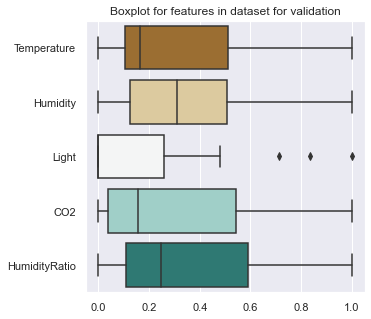

In [28]:
box_plots(dataset, "dataset for validation")

There are three features with extreme values in the testing dataset - `Temperature`, `Light`, and `CO2`.

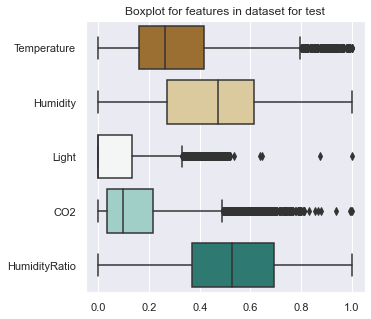

In [29]:
box_plots(dataset2, "dataset for test")

On the other hand, there are not `Temperature` outliers in the training data. However, not only `Light` and `CO2` but `HumidityRation` also holds extreme values.

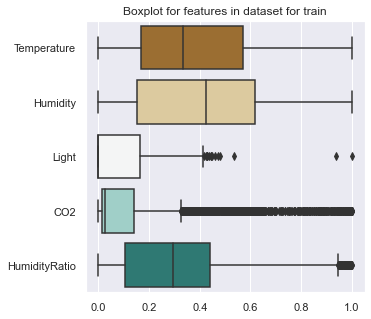

In [30]:
box_plots(datatraining, "dataset for train")

### 2.6. Explore correlation

Correlation explains how one or more variables are related to each other. Positive correlation is observed when two features (variables) are positively correlated with each other. It means that when the value of one variable increases, the value of the other variable(s) also increases. Two features (variables) are negatively correlated with each other when the value of the first variable increases, the value of the other variable(s) decreases. If two variables are closely correlated, then one variable can be predicted from the other. 

The function below helps for plotting a correlation matrix, which shows the correlation coefficient for all features.

In [31]:
def show_correlation_matrix(dataframe, df_type):
    """
    Displays correlation matrix.
    Args:
        Pandas DataFrame
    """
    plt.figure(figsize = (7, 5))
    plt.title(f"Correlation table for features in {df_type}", fontdict = {"fontsize": 12})
    ax = sns.heatmap(dataframe.corr(), vmin = -1.0, vmax = 1.0, annot = True, linewidths = 0.2, cmap = plt.cm.BrBG)
    plt.show()

With regard to validation data, there is a strong positive correlation between `Humidity` and `HumidityRatio`, `CO2` and `HumidityRatio`, and `Light` and `Occupancy`.

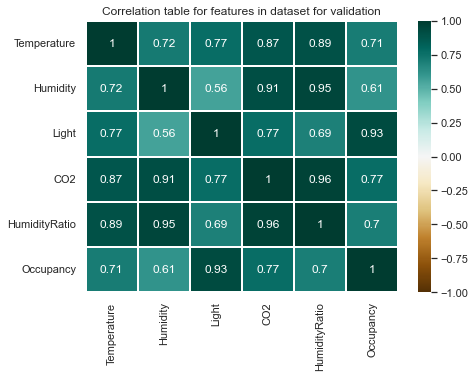

In [32]:
show_correlation_matrix(dataset, "dataset for validation")

On the other hand, there is a negative relationship between `CO2` and `Humidity` in the testing data. The Link between `Light` and `Occupancy` is confirmed.

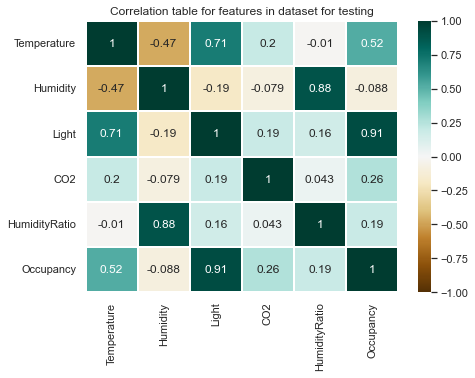

In [33]:
show_correlation_matrix(dataset2, "dataset for testing")

A stong positive correlation between `Light` and `Occupancy` is visible in the third dataset, too.

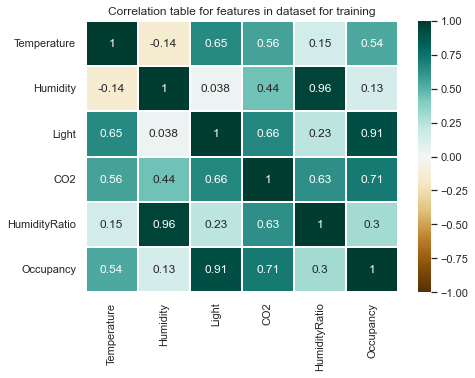

In [34]:
show_correlation_matrix(datatraining, "dataset for training")

### 2.7. Explore `Occupancy`

`Occupancy` holds binary values - 1 indicates the room is occupied, and 0 - not occupied. The function below displays counts in each dataset.

In [35]:
def plot_counts(dataframe, df_type):
    """
    Displays counts per each class in a dataframe
    Args:
        Pandas DataFrame
    """
    sns.set(style = "darkgrid")
    plt.title(f"Occupancy Distribution in {df_type}", fontdict={'fontsize':12})
    ax = sns.countplot(x = "Occupancy", data = dataframe, palette = "BrBG")
    plt.show()

There are twice as many samples recorded when the room was not occupied in validation data.

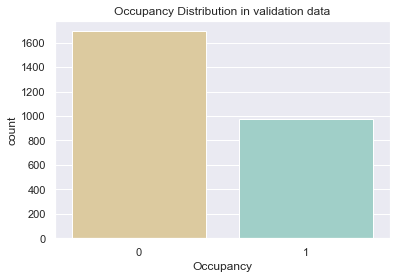

In [36]:
plot_counts(dataset, "validation data")

In test data, this ratio is 3.5 : 1. This dataset is much more imbalanced.

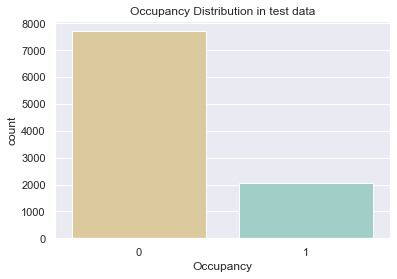

In [37]:
plot_counts(dataset2, "test data")

Similarly, there are much less datapoints recorded when the room was occupied in the training data.

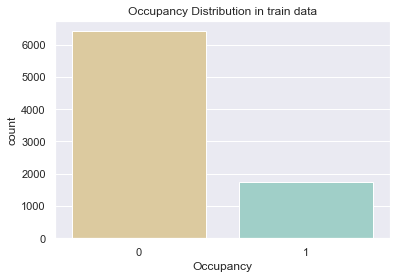

In [38]:
plot_counts(datatraining, "train data")

The plots above show that all three dataset are quite unbalanced. To address this issue to a certain extent, and to strenghten predictions, another relationship between occupancy and day time is proposed.

### 2.8. Add `period_of_day` column

A column indicating the period of the day is added to each dataset. To illustrate occupancy throughout the whole day, two variables store number of samples for occupied and not occupied room.

In [39]:
hours_1 = []
hours_0 = []
for date in dataset[dataset['Occupancy'] == 1]['date']:
    hours_1.append(date.hour)
for date in dataset[dataset['Occupancy'] == 0]['date']:
    hours_0.append(date.hour)

The room was occupied between 7.00 am and 18.00 pm (see below). There are two peaks - around 10.00 am and around 4.00 pm. Room was rarely occupied during lunch time. During night time, it was empty.

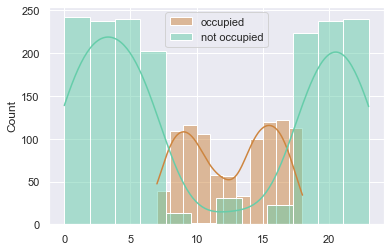

In [40]:
plt.figure(figsize = (6, 4))
ax = sns.histplot(hours_1, color = "peru", label = "occupied", kde = True)
ax = sns.histplot(hours_0, color = "mediumaquamarine", label = "not occupied", kde = True)
plt.legend()
plt.show()

This information helps to create a new feature, where 1 will indicate working hours (07:00 - 18:00), and 0 - the rest of the day (non-working hours).

In [41]:
def add_period_of_day(dataframe):
    """"
    Adds a column showing period of day: 1 busy hours, and 0 - for non-busy hours.
    Args:
        Pandas DataFrame
    Return:
        Pandas DataFrame with column "period_of_day".
    """
    dataframe["period_of_day"] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in dataframe["date"]]
    
    return dataframe

In [42]:
dataset = add_period_of_day(dataset)
dataset2 = add_period_of_day(dataset2)
datatraining = add_period_of_day(datatraining)

A piece of the training data is shown below. The last column (`period_of_day`) holds information as to if the sample was recorded during working time, or outside it.

In [43]:
datatraining.sample(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,period_of_day
293,2015-02-04 22:44:00,0.547847,0.400268,0.0,0.040384,0.354204,0,0
6361,2015-02-09 03:52:00,0.093301,0.444966,0.0,0.032957,0.273180,0,0
6438,2015-02-09 05:09:00,0.093301,0.446977,0.0,0.034195,0.274836,0,0
1952,2015-02-06 02:23:00,0.382775,0.120684,0.0,0.014080,0.062204,0,0
5938,2015-02-08 20:49:00,0.093301,0.475807,0.0,0.022435,0.298571,0,0


## 3. Data Pre-processing

Data pre-processing steps should prepare the datasets for modelling. First, features and labels are separated. Thereafter, I check shapes, and further explore sequences to find out that the provided datasets are in the wrong order. To remedy this situation, I concatenate the three datasets in the proper order, and visualize them. Thereafter, I split all data into train-validation-test sets but keep as many samples as possible for training.

### 3.1. Separate features from labels

The function below stores features in one variable (X), and labels - in another (y). This pre-processing step is needed since the data are modelled with supervised machine learning algorithms, which expect to see data (X) and the true answer (y). `date` column is removed, since modelling algorithms can't handle values other than *numpy arrays* or *tensors*. Both `sklearn` and `Keras` functions work with `date` as index but models do not perform better. For this reason, I stick to the approach proposed by the author of the cited Notebook.

In [44]:
def separate_features_and_labels(dataframe):
    """
    Separates features from labels
    Args:
        Pandas DataFrame
    Return
        X: features
        y: labels
    """
    X = dataframe.drop(columns = ["date", "Occupancy"], axis = 1)
    y = dataframe["Occupancy"]
    
    return X, y

In [45]:
X_train, y_train = separate_features_and_labels(dataset)
X_val, y_val = separate_features_and_labels(datatraining)
X_test, y_test = separate_features_and_labels(dataset2)

If I had used the datasets in thier logical sequence, train data would have had only 2665 samples. On the other hand, the models would have been validated and tested on much larger sets. Thus, it could turn out that they might not have seen all possible relationships between variables.

In [46]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2665, 6), (2665,), (8143, 6), (8143,), (9752, 6), (9752,))

### 3.2 Concatenate the 3 datasets

This confusion is remedied by concatenating the three datasets in a proper chronological order.

In [47]:
dataset_all = pd.concat([dataset, datatraining, dataset2])
dataset_all.reset_index(inplace = True)

`date` needs to be set as index to display dates and hours on a plot. However, I copy and store all samples in a new variable to avoid mismatch at a later stage.

In [48]:
dataset_all_copy = dataset_all.copy()
dataset_all_copy.set_index("date", inplace = True)

The plot below shows the parameters from all three datasets and how their values fluctuate over time. It seems there are not values around 11-th and 12-th of February, but a simple check proved this is not the case.

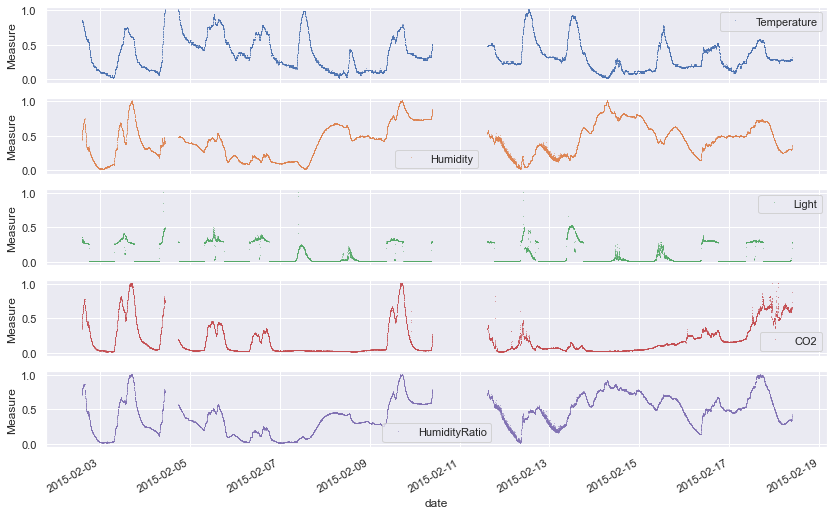

In [49]:
plot_params_against_time(dataset_all_copy)

I return `date` as a feature...

In [50]:
dataset_all_copy.reset_index(inplace = True)
dataset_all_copy.head()

,date,index,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,period_of_day
0,2015-02-02 14:19:00,0,0.831683,0.445132,0.344793,0.330033,0.704212,1,1
1,2015-02-02 14:19:59,1,0.835960,0.447053,0.340787,0.341523,0.708308,1,1
2,2015-02-02 14:21:00,2,0.838812,0.440651,0.337409,0.351030,0.704689,1,1
3,2015-02-02 14:22:00,3,0.837030,0.429448,0.290912,0.356245,0.694383,1,1
4,2015-02-02 14:23:00,4,0.844515,0.437450,0.287877,0.360605,0.705384,1,1


... and remove the unnecessary `index` column.

In [51]:
dataset_all_copy.drop(["index"], axis = 1, inplace = True)
dataset_all_copy.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,period_of_day
0,2015-02-02 14:19:00,0.831683,0.445132,0.344793,0.330033,0.704212,1,1
1,2015-02-02 14:19:59,0.835960,0.447053,0.340787,0.341523,0.708308,1,1
2,2015-02-02 14:21:00,0.838812,0.440651,0.337409,0.351030,0.704689,1,1
3,2015-02-02 14:22:00,0.837030,0.429448,0.290912,0.356245,0.694383,1,1
4,2015-02-02 14:23:00,0.844515,0.437450,0.287877,0.360605,0.705384,1,1


### 3.3. Split data into train, validation, and test set

Scikit-learn's `train-test-split` is not appropriate for splitting time series data. One of its best properties is making stratified split, i.e., withholding similar share of samples of each class in train and test data. However, predictions of time series are based on previous behaviour. Thus, train data should precede validation, and test should have had happened thereafter.

For this reason, I choose midnight on 17-th Feb, 2015 as a cut-off date. All samples thereafter are used for testing. Similarly, samples recorded after midnight on 15-th Feb, 2015 are set aside for validation. The code blocks below do the train-validation-test split as explained.

In [52]:
split_date = "2015-02-17 00:00:00"
tr_data = dataset_all_copy.loc[dataset_all_copy["date"] <= split_date]
test_data = dataset_all_copy.loc[dataset_all_copy["date"] > split_date]

In [53]:
split_date = "2015-02-15 00:00:00"
train_data = tr_data.loc[tr_data["date"] <= split_date]
val_data = tr_data.loc[tr_data["date"] > split_date]

In [54]:
X_train, y_train = separate_features_and_labels(train_data)
X_val, y_val = separate_features_and_labels(val_data)
X_test, y_test = separate_features_and_labels(test_data)

A brief check shows that all sets are in the proper shape. There are 15681 train samples, 2880 for model validation, and 1999 - for final test.

In [55]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15681, 6), (15681,), (2880, 6), (2880,), (1999, 6), (1999,))

## 4. Classification with Machine Learning algorithms

Two classical Machine Learning algorithms and four Neural Networks are tried and tested to model the data.

### 4.1. KNN (K-nearest neighbors)

`KNeighborsClassifier` implements learning based on the *k* nearest neighbors of each query point, where *k* is an integer value specified by the user. The optimal choice of the *k* value is highly data-dependent: in general a larger *k* suppresses the effects of noise, but makes the classification boundaries less distinct. 

KNN has several tunable hyper-parameters. The most common ones are *n_neighbors, weights and metrics*. Their possible values are stored is lists. *n_neighbors* indicates the number of neighbors to be used by default for kneighbors queries. *weights* shows the weight function used in prediction. Possible values are: "uniform" when all points in each neighborhood are weighted equally; and "distance" when points are weighted by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. *metrics* indicates the distance metric to be used for the tree. The default one is *minkowski*. The author of the cited example explores *euclidean* and *manhattan* distance.

*accuracies* is an empty dictionay, which stores accuracy values of all possible hyper-parameters combinations.

In [56]:
n_neighbors_list = [7, 15, 45, 135]
weights_list = ["uniform", "distance"]
metric_list = ["euclidean", "manhattan"]
accuracies = {}

In [57]:
for n in n_neighbors_list:
    for weight in weights_list:
        for metric in metric_list:
            knn_model = KNeighborsClassifier(n_neighbors = n, weights = weight, metric = metric)
            knn_model.fit(X_train, y_train)
            accuracy = knn_model.score(X_val, y_val)
            accuracies[str(n) + "/" + weight + "/" + metric] = accuracy

In [58]:
accuracies

{'7/uniform/euclidean': 0.8645833333333334,
 '7/uniform/manhattan': 0.8444444444444444,
 '7/distance/euclidean': 0.8645833333333334,
 '7/distance/manhattan': 0.8444444444444444,
 '15/uniform/euclidean': 0.8739583333333333,
 '15/uniform/manhattan': 0.8440972222222223,
 '15/distance/euclidean': 0.8739583333333333,
 '15/distance/manhattan': 0.8440972222222223,
 '45/uniform/euclidean': 0.8677083333333333,
 '45/uniform/manhattan': 0.8534722222222222,
 '45/distance/euclidean': 0.86875,
 '45/distance/manhattan': 0.8534722222222222,
 '135/uniform/euclidean': 0.8652777777777778,
 '135/uniform/manhattan': 0.8572916666666667,
 '135/distance/euclidean': 0.8659722222222223,
 '135/distance/manhattan': 0.8565972222222222}

Accuracies are converted into a `Pandas DataFrame` to simplify plotting.

In [59]:
plotdata = pd.DataFrame()
plotdata["Parameters"] = accuracies.keys()
plotdata["Accuracy"] = accuracies.values()

In [60]:
fig = px.line(plotdata, x = "Parameters", y = "Accuracy")
fig.update_layout(title = {"text": "Accuracies for different hyper-parameters",
                    "x": 0.5, "xanchor": "center", "yanchor": "top"})
iplot(fig)

The graph reveals that:

- 15 is enough for k-value.
- Euclidean distance performs better. 
- Both Uniform and Distance weights peform well.

The best performing combination of hyper-parameters is set in the modelling algorithm.

The code block below trains the model and computes predictions.

In [61]:
knn_model = KNeighborsClassifier(n_neighbors = 15, weights = "distance", metric = "euclidean")
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_val)
print(f"Accuracy for KNN on validation data: {round((knn_model.score(X_val, y_val) * 100), 2)}%.")

Accuracy for KNN on validation data: 87.4%.


Model accuracy on validation data is far from satisfactory. Misclassified samples are displayed on a confusion matrix. It shows number of predicted vs actual class of samples.

In [62]:
def plot_confusion_matrix(y_true, y_pred, model_name, data_type):
  """
  Plots confusion matrix
  Args:
    y_true: real labels 
    y_pred: predicted labels
    model_name: string of model name
    data_type: string stating dataset type
  """
  ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt = "d", cmap = plt.cm.BrBG)
  plt.title(f"{model_name} Confusion matrix for {data_type} data", fontdict = {"fontsize": 14})
  plt.ylabel("Predicted values")

2072 samples of class 0 (room was not occupied) in validation data were properly predicted, whereas 106 were not. On the other hand, more than 50% of class 1 (257 samples) were wrongly placed in class 0. 

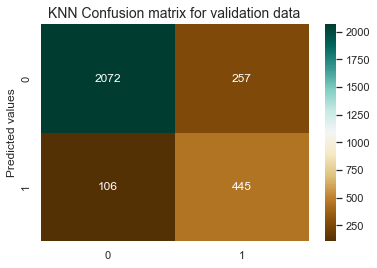

In [63]:
plot_confusion_matrix(y_val, y_pred, "KNN", "validation")

### 4.2 Support Vector Machine

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. Among their advantages is that they are effective in high dimensional spaces, especially when number of dimensions is greater than the number of samples. `SVC()` is used with its default hyper-parameter values. e.g., *C* = 1.0 (no regularization), rbf *kernel*, and so forth.

In [64]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_val)
print(f"Accuracy for SVM on validation data: {round((svm_model.score(X_val, y_val) * 100), 2)}%")

Accuracy for SVM on validation data: 97.26%


SVM peforms much better on validation data. Accuracy exceeds 97%. Furthermore, it didn't misclassify any samples of class 0, and couldn't predict 79 samples of class 1. 

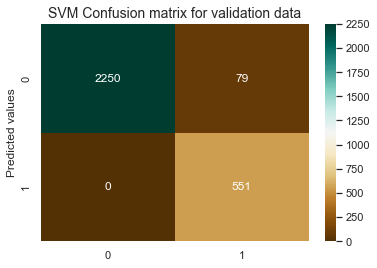

In [65]:
plot_confusion_matrix(y_val, y_pred, "SVM", "validation")

## 5. Classification with Neural Networks

Four different Neural Networks were tried and tested - with or without regularization:

- Without regularization
- With 0.2 dropout rate
- With L1(Lasso) regularization
- With L2(Ridge) regularization

All Neural Networks have an input layer, one output layer and one hidden Dense layer. Input layers have 32 neurons, hidden layer - 16 neurons, and the output layer - 1 neuron. Input and hidden layers compute weights with *ReLU* activation function. The output layer uses *sigmoid*, which is used for classification tasks.

Train and validation loss and metrics are displayed for each model. At the end, there is a plot comparing all losses.

### 5.1. Neural Network without Regularization

In [66]:
tf.keras.backend.clear_session()

In [67]:
model1 = Sequential([
    Dense(32, activation = "relu", input_dim = 6),
    Dense(16, activation = "relu"),
    Dense(1, activation = "sigmoid")
])

`model.summary()` is displayed only for this Neural Network to show model architecture. It has 769 trainable parameters. Input layer has 224 parameters - each neuron gets values from 6 input variables (32 * 6 = 192); weights are adjusted with bias terms (32). The hidden layer has 16 neurons, which get input data from 32 neurons (32 * 16 = 512) and 16 bias terms. The last layer has 1 neuron, which gets data from 16 units from the previous (hidden) layer.

In [68]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


The model is compiled with `rmsprop` optimizer (an algorithm computing and adhusting weights and learning rate in order to reduce the loss), `binary_crossentropy` to compute loss (used for solving binary classification problems), and `accuracy` to measure model performance.

In [69]:
model1.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

Model training and validation is performed over 50 epochs on batches of 32 samples. *verbose* is set to 0 to hide training and validation progress lines.

In [70]:
history1 = model1.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_val, y_val), verbose = 0)

In [71]:
def plot_graphs(history, string):
    """
    Displays changes in monitored loss and metrics during model training
    Args: 
        Monitoring logs
    Return: 
        A line graph with changes of loss and metrics over time
    """
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

Non-regularized model do not perfom so well - both validation loss and accuracy are unstable, which might be an indication of overfitting. 

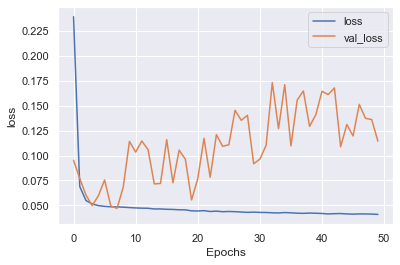

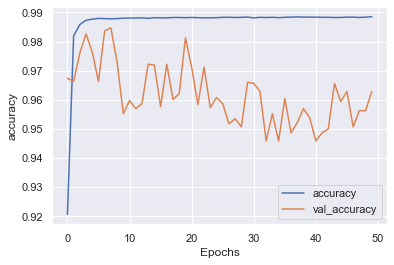

In [72]:
plot_graphs(history1, "loss")
plot_graphs(history1, "accuracy")

### 5.2. Neural Network with a `Droput` layer

The second Neural Net has a `Dropout` layer which randomly removes 20% of training samples.

In [73]:
tf.keras.backend.clear_session()

In [74]:
model2 = Sequential([
    Dense(32, activation = "relu", input_dim = 6),
    Dropout(0.2),
    Dense(16, activation = "relu"),
    Dense(1, activation = "sigmoid")
])

In [75]:
model2.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

In [76]:
history2 = model2.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_val, y_val), verbose = 0)

It seems the `Dropout` layer makes the model more stable. Validation loss is smoother, and accuracy barely falls below 97%.

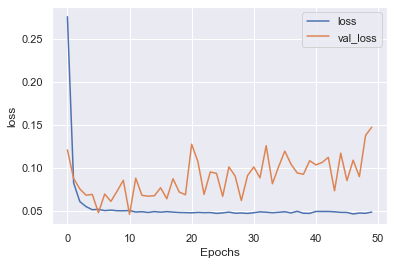

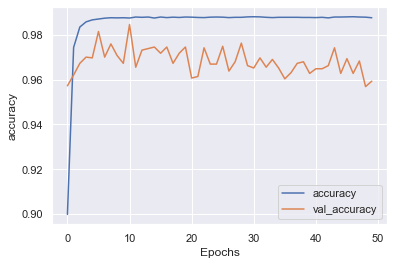

In [77]:
plot_graphs(history2, "loss")
plot_graphs(history2, "accuracy")

### 5.3. Neural Network with `L1 (Lasso) Regularization`

L1 regularization (add “absolute value of magnitude” of coefficient as penalty term to the loss function) is applied to input and hidden layers with coefficient of 0.1.

In [78]:
tf.keras.backend.clear_session()

In [79]:
model3 = Sequential([
    Dense(32, activation = "relu", input_dim = 6, kernel_regularizer = l1(l = 0.01)),
    Dense(16, activation = "relu", kernel_regularizer = l1(l = 0.01)),
    Dense(1, activation = "sigmoid")
])

In [80]:
model3.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

In [81]:
history3 = model3.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_val, y_val), verbose = 0)

Regularized model returns much better results - validation loss is slighly lower than the loss on training data (which could be explained with the smaller number of validation samples), and validation accuracy fluctuates around 98%.

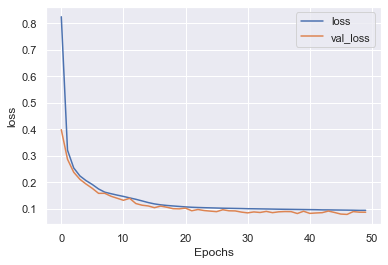

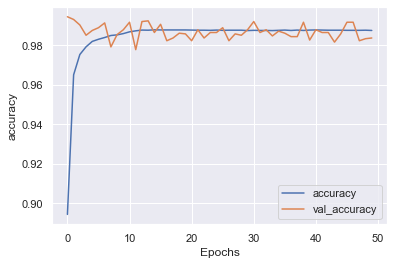

In [82]:
plot_graphs(history3, "loss")
plot_graphs(history3, "accuracy")

### 5.4. Neural Network with `L2 (Ridge) Regularization`

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. This technique works very well to avoid over-fitting.

In [83]:
tf.keras.backend.clear_session()

In [84]:
model4 = Sequential([
    Dense(32, activation = "relu", input_dim = 6, kernel_regularizer = l2(l = 0.01)),
    Dense(16, activation = "relu", kernel_regularizer = l2(l = 0.01)),
    Dense(1, activation = "sigmoid")
])

In [85]:
model4.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

In [86]:
history4 = model4.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_val, y_val), verbose = 0)

L2 regularization makes the model to reach almost 99% accuracy and around 0.05 loss on validation data.

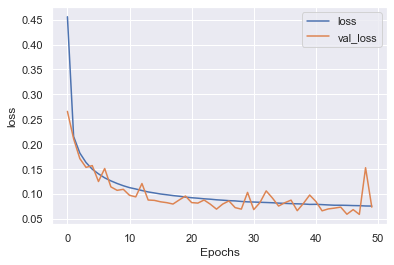

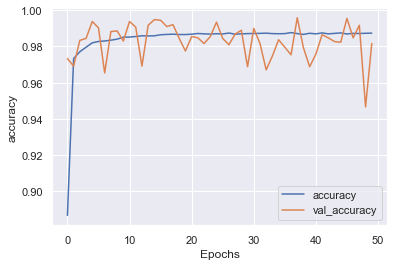

In [87]:
plot_graphs(history4, "loss")
plot_graphs(history4, "accuracy")

#### Compare loss of all 4 models

In [88]:
loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]
loss3 = history3.history["loss"]
val_loss3 = history3.history["val_loss"]
loss4 = history4.history["loss"]
val_loss4 = history4.history["val_loss"]

In [89]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = np.arange(len(loss1)), y = loss1, name = "Training loss without Regularization", line=dict(color = "royalblue")))
fig.add_trace(go.Scatter(x = np.arange(len(val_loss1)), y = val_loss1, name = "Validation loss without Regularization", line=dict(color = "firebrick")))

fig.add_trace(go.Scatter(x = np.arange(len(loss2)), y = loss2, name = "Training loss with Dropout", line=dict(color = "royalblue", dash = "dash")))
fig.add_trace(go.Scatter(x = np.arange(len(val_loss2)), y = val_loss2, name = "Validation loss with Dropout", line=dict(color = "firebrick", dash = "dash")))

fig.add_trace(go.Scatter(x = np.arange(len(loss3)), y = loss3, name = "Training loss with L1 Regularization", line=dict(color = "royalblue", dash = "dot")))
fig.add_trace(go.Scatter(x = np.arange(len(val_loss3)), y = val_loss3, name = "Validation loss with L1 Regularization", line=dict(color = "firebrick", dash = "longdashdot")))

fig.add_trace(go.Scatter(x = np.arange(len(loss4)), y = loss4, name = "Training loss with L2 Regularization", line=dict(color = "royalblue", dash = "dot")))
fig.add_trace(go.Scatter(x = np.arange(len(val_loss4)), y = val_loss4, name = "Validation loss with L2 Regularization", line=dict(color = "firebrick", dash = "longdashdot")))

fig.update_layout(xaxis_title = "Epochs", yaxis_title = "Loss",
                    title = {"text": "Training and validation Losses for Different Neural Networks",
                            "x": 0.5, "xanchor": "center", "yanchor": "top"})
iplot(fig)

It could be concluded that:

- NN without regularization is unstable as expected.
- Dropout and L2 regularization makes the model to perform well.
- L1 regularization is stable but has higher loss value.

P.S. You can click on the legend to inspect selected lines. It might be useful for examining the plot.

So the best option will be a model with a `Dropout` layer and L2 regularization on input and hidden layers.

In [90]:
tf.keras.backend.clear_session()

In [91]:
model = Sequential([
    Dense(32, activation = "relu", input_dim = 6, kernel_regularizer = l2(l = 0.01)),
    Dropout(0.2),
    Dense(32, activation = "relu", kernel_regularizer = l2(l = 0.01)),
    Dense(1, activation = "sigmoid")
])

In [92]:
model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

In [93]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_val, y_val), verbose = 0)

A model combining `Dropout` and `L2` regularization returns loss below 0.1 and accuracy around and above 98% on validation data.

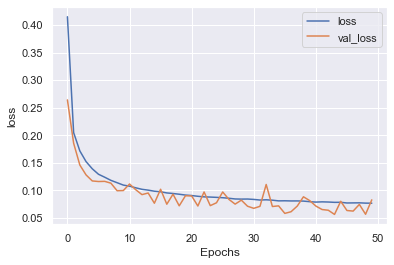

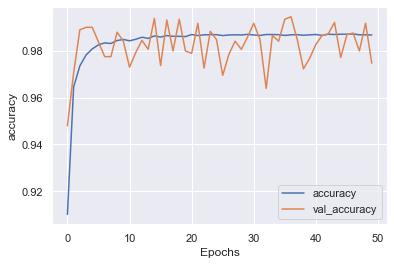

In [94]:
plot_graphs(history, "loss")
plot_graphs(history, "accuracy")

## 6. Compare SVM and Neural Network performance
SVM and the Neural Network are evaluated on the test data. Both models perform really well: SVM reaches 99.55% accuracy, and the Neural Net - 99.65% accuracy.

In [95]:
print(f"Accuracy for SVM on test data: {round((svm_model.score(X_test, y_test) * 100), 2)}%.")
print(f"Accuracy for Neural Network model on test data: {round((model.evaluate(X_test, y_test)[1] * 100), 2)}%.")

Accuracy for SVM on test data: 99.55%.
1999/1999 [==============================] - 0s 63us/sample - loss: 0.0656 - accuracy: 0.9960
Accuracy for Neural Network model on test data: 99.6%.


SVM misclassified only 3 class 0 samples, and only 6 class 1 samples.

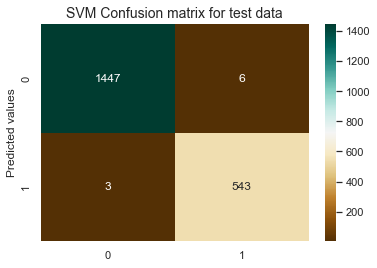

In [96]:
y_pred = svm_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "SVM", "test")

The Neural Net wrongly predicted only 1 class 0 sample, and 6 class 1 sample.

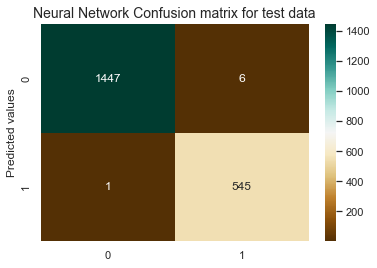

In [97]:
y_pred = model.predict(X_test)
threshold = 0.6
y_pred = [1 if i >= threshold else 0 for i in y_pred]
plot_confusion_matrix(y_test, y_pred, "Neural Network", "test")


## 6. Conclusion

It turned out that both - the SVM and a regularized Neural Network - predict well a room occupancy. Accuracy on the test data exceeds 99.5%. Furthermore, the cited Notebook revealed that SVM model looks like biased toward occupied class, which is not the case with the Neural Network. However, addressing the train-validation-test split issue removes this bias and both models perfom equally well.
